In [19]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data

from models import NN, NNOPT
from utils import load_data, get_scaledABb, Data_cstr, PINNLoss, Data_plant, Data_distillation
import time
import copy

In [20]:
input_dim = 3
hidden_dim = 12
hidden_num = 1
z0_dim = 3
epochs = 1000
batch_size = 16
lr = 1e-4
eta = 1
val_ratio = 0.2
dataset_path = 'benchmark_CSTR.csv'

In [21]:
dataset_arr, scaler = load_data(dataset_path)
Data_class = Data_cstr

params = {'batch_size': batch_size,
              'shuffle': True}
dataset = Data_class(dataset_arr)
dataset.resplit_data(val_ratio)

A, B, b = get_scaledABb(dataset.A, dataset.B, dataset.b, scaler)
print((torch.mm(A, dataset.X.T.float()) + torch.mm(B, dataset.Y.T.float()))[:, :5])
print(b)

train_loader = data.DataLoader(dataset.train_set, **params)
val_loader = data.DataLoader(dataset.val_set, **params)
test_loader = data.DataLoader(dataset.test_set, **params)

tensor([[-1.9073e-06,  0.0000e+00,  0.0000e+00,  7.6294e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  7.6294e-06,  0.0000e+00]])
tensor([0., 0.])


In [22]:
NN_model = NN(input_dim, hidden_dim, hidden_num, z0_dim)
PINN_model = NN(input_dim, hidden_dim, hidden_num, z0_dim)
NNOPT_model = NNOPT(input_dim, hidden_dim, hidden_num, z0_dim, A, B, b)

In [23]:
def test(model, test_loader, loss_func):
    model.eval()
    test_loss = 0
    test_violation = 0
    expanded_b = b.unsqueeze(1)

    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(test_loader):
            pred = model(X)
            pred_diff = torch.mm(A, X.T.float()) + \
                        torch.mm(B, pred.T.float()) - \
                        expanded_b.repeat(1, X.T.shape[1])
            if isinstance(loss_func, PINNLoss):
                test_loss += nn.MSELoss()(pred, Y).item()  # return and record the MSE loss for comparison
            elif isinstance(loss_func, nn.MSELoss):
                test_loss += loss_func(pred, Y).item()
            else:
                raise ValueError('Loss function not supported!')
            test_violation += torch.abs(pred_diff.view(-1)).mean()
    test_loss /= len(test_loader.dataset)  # Test set Average loss
    test_violation /= len(test_loader.dataset)  # Test set Average violation
    return test_loss, test_violation

In [24]:
def train(model, train_loader, val_loader, loss_func):
    expanded_b = b.unsqueeze(1)
    t_total = time.time()
    print('Start Training...')
    min_loss = 123456789
    train_losses = []
    val_losses = []
    train_violations = []
    val_violations = []
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        t = time.time()
        print('-------- Epoch ' + str(epoch + 1) + ' --------')

        model.train()
        train_loss = 0
        train_violation = 0
        for batch_idx, (X, Y) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(X)
            pred_diff = torch.mm(A, X.T.float()) + \
                        torch.mm(B, pred.T.float()) - \
                        expanded_b.repeat(1, X.T.shape[1])

            if isinstance(loss_func, PINNLoss):
                loss = loss_func(X, pred, Y)
                loss2record = nn.MSELoss()(pred, Y)
                train_loss += loss2record.item()
            elif isinstance(loss_func, nn.MSELoss):
                loss = loss_func(pred, Y)
                train_loss += loss.item()
            else:
                raise ValueError('Loss function not supported!')

            train_violation += torch.abs(pred_diff.view(-1)).mean()

            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader.dataset)
        train_violation /= len(train_loader.dataset)
        val_loss, val_violation = test(model, val_loader, loss_func)
        train_losses.append(train_loss), train_violations.append(train_violation.detach().item())
        val_losses.append(val_loss), val_violations.append(val_violation.detach().item())

        if np.mean(val_loss) < min_loss:
            model_max = copy.deepcopy(model)
            min_loss = np.mean(val_losses[-1])
            # torch.save(model, path)
        print('epoch: {:05d}'.format(epoch + 1),
              'loss_train: {:.5f}'.format(train_loss),
              'loss_val: {:.5f}'.format(val_loss),
              'violation_train: {:.5f}'.format(train_violation),
              'violation_val: {:.5f}'.format(val_violation),
              'time: {:.4f}s'.format(time.time() - t))
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    return train_losses, val_losses, train_violations, val_violations, model_max

In [25]:
# only take 1 run here
NN_train_losses, NN_val_losses, \
            NN_train_violations, NN_val_violations, \
            NN_model_max = train(NN_model, train_loader, val_loader, nn.MSELoss())

PINN_train_losses, PINN_val_losses, \
            PINN_train_violations, PINN_val_violations, \
            PINN_model_max = train(PINN_model, train_loader, val_loader, PINNLoss(A, B, b, eta))

NNOPT_train_losses, NNOPT_val_losses, \
            NNOPT_train_violations, NNOPT_val_violations, \
            NNOPT_model_max = train(NNOPT_model, train_loader, val_loader, nn.MSELoss())

Start Training...
-------- Epoch 1 --------
epoch: 00001 loss_train: 0.00540 loss_val: 0.00582 violation_train: 1.87260 violation_val: 1.98222 time: 0.0570s
-------- Epoch 2 --------
epoch: 00002 loss_train: 0.00501 loss_val: 0.00542 violation_train: 1.81229 violation_val: 1.91614 time: 0.0501s
-------- Epoch 3 --------
epoch: 00003 loss_train: 0.00473 loss_val: 0.00510 violation_train: 1.76044 violation_val: 1.87692 time: 0.0493s
-------- Epoch 4 --------
epoch: 00004 loss_train: 0.00449 loss_val: 0.00492 violation_train: 1.71225 violation_val: 1.82973 time: 0.0513s
-------- Epoch 5 --------
epoch: 00005 loss_train: 0.00428 loss_val: 0.00469 violation_train: 1.66359 violation_val: 1.78546 time: 0.0492s
-------- Epoch 6 --------
epoch: 00006 loss_train: 0.00410 loss_val: 0.00460 violation_train: 1.61537 violation_val: 1.76561 time: 0.0483s
-------- Epoch 7 --------
epoch: 00007 loss_train: 0.00392 loss_val: 0.00435 violation_train: 1.56405 violation_val: 1.66760 time: 0.0483s
-------- 

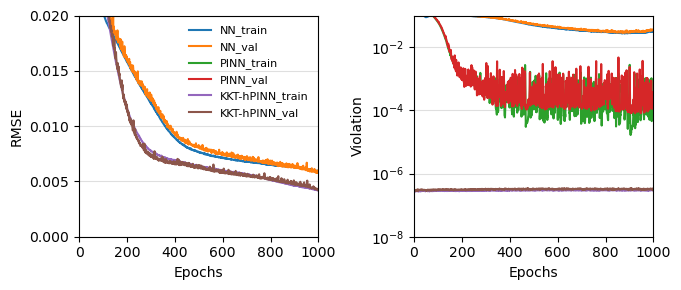

In [26]:
# the figure here is not the same as the one in the paper
# the figure in the paper is the average result of 10 runs
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].plot(np.sqrt(NN_train_losses), label='NN_train')
axs[0].plot(np.sqrt(NN_val_losses), label='NN_val')

axs[0].plot(np.sqrt(PINN_train_losses), label='PINN_train')
axs[0].plot(np.sqrt(PINN_val_losses), label='PINN_val')

axs[0].plot(np.sqrt(NNOPT_train_losses), label='KKT-hPINN_train')
axs[0].plot(np.sqrt(NNOPT_val_losses), label='KKT-hPINN_val')

axs[0].grid(True, alpha=0.4, linestyle='-', axis='y')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('RMSE')
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 2e-2)
axs[0].legend(frameon=False, prop={'size': 8})


axs[1].plot(NN_train_violations, label='NN_train')
axs[1].plot(NN_val_violations, label='NN_val')

axs[1].plot(PINN_train_violations, label='PINN_train')
axs[1].plot(PINN_val_violations, label='PINN_val')

axs[1].plot(NNOPT_train_violations, label='KKT-hPINN_train')
axs[1].plot(NNOPT_val_violations, label='KKT-hPINN_val')

axs[1].set_yscale('log')
axs[1].grid(True, alpha=0.4, linestyle='-', axis='y')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Violation')
axs[1].set_xlim(0, 1000)
axs[1].set_ylim(1e-8, 1e-1)
# axs[1].legend(frameon=False, prop={'size': 8})

plt.tight_layout()
plt.show()